## Imports

In [ ]:
!pip install nbresult matplotlib==3.5.3 matplotlib-inline==0.1.6 numpy==1.23.4 pandas seaborn==0.11.2 scipy xgboost scikit-learn


In [1]:
# Carregue os imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


🏆 Desafio em Lote do Kaggle
============================

**Bem-vindo à sua primeira competição no Kaggle!**

Seu objetivo é **submeter uma resposta (online)** para a competição aberta [Preços de Casas - Técnicas Avançadas de Regressão](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 🏠

Você será semi-orientado para um **modelo de base**, e somente após criar esse modelo de base você estará livre para aprimorá-lo e refiná-lo. Abordaremos o problema usando **pipelines** (a melhor prática)!

Algumas palavras sobre o Kaggle:

* O Kaggle classificará sua submissão entre todos os participantes!
* Todos são removidos do ranking público após 2 meses
* Você pode fazer até 10 submissões por dia

🧹 Hoje é o dia perfeito para praticar manter seu longo caderno **organizado** 🧹

* Colapse todos os títulos a partir da paleta de comandos (`Cmd + Shift + P`)
* Mantenha-se "idempotente" (`Restart & Run All` nunca deve falhar)
* Nomeie e delete variáveis com cuidado

Configuração do Kaggle
----------------------

👉 Crie uma conta no Kaggle se quiser participar da competição

👉 Junte-se ao [Desafio de Preços de Casas](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Carregando Dados
----------------

Nas instruções do desafio, você já deveria ter executado os passos para baixar tudo o que precisa do Kaggle para a pasta atual do seu notebook:

* `train.csv` é o seu conjunto de treinamento `(1460, 81)` contendo `X` e `y`
* `test.csv` é o seu conjunto de teste `(1459, 80)` sem o alvo associado `y` 😈
* `sample_submission.csv` descreve o formato necessário para submeter sua resposta

Seu objetivo é prever o `y_pred` que falta no seu conjunto de teste e submetê-lo para descobrir seu `test_score` e classificação

❓ Carregue o conjunto de dados de treinamento em um DataFrame chamado `data`, e crie seu `X` e `y`. Inspecione seus formatos.

**Dica:** se você verificar o arquivo CSV, notará uma coluna chamada `Id`. Ao ler o arquivo CSV em um DF, certifique-se de definir `index_col="Id"` para que você não tenha duas colunas de ID 😉

In [2]:
# Vamos fazer o load dos dados na variável 'data'
data = pd.read_csv('data/houses_train_raw.csv', index_col='Id')
data


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [3]:
# Vamos fazer o drop da coluna SalePrice

X = data.drop(columns=['SalePrice'])
y = data.SalePrice

X.shape, y.shape


((1460, 79), (1460,))

# 🐣 1. BASELINE

1.1 Visão inicial das características
-------------------------------------

80 características são demais para lidar individualmente para um primeiro pipeline de base! Vamos tratá-las baseando-nos somente em seu `dtype`:

❓ Quantas características numéricas versus características categóricas temos?

In [4]:
X.dtypes.value_counts()


object     43
int64      33
float64     3
dtype: int64

❓ Crie uma Série chamada `feat_categorical_nunique` contendo o número de **valores únicos** para cada característica categórica no nosso conjunto de treinamento. Quantas categorias únicas existem no total?

In [5]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()


In [6]:
feat_categorical_nunique.sum()


252

🤔 Se fôssemos para o `OneHotEncode`, em todas as características categóricas, nossa matriz de características `X_preproc` se tornaria bastante grande e esparsa, com quase 300 características (altamente correlacionadas) para apenas 1400 observações. Idealmente, deveríamos visar alimentar nosso modelo com um máximo de ~50 características (📚 leia esta [regra prática](https://datascience.stackexchange.com/a/11480/98300))

Conhecemos 2 principais estratégias para reduzir o número de características categóricas após o pré-processamento:

1. **[Remover](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** características que trazem pouca explicação para nosso modelo; isso pode exigir análise estatística da importância das características
2. **[Codificar ordinalmente](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (em vez de usar one-hot encode) características categóricas em inteiros; isso, no entanto, cria uma noção de "ordem" (1 > 2 > 3 > ...) que pode ser prejudicial se não for manuseada corretamente!

❓ Plote o histograma do número de valores únicos por característica categórica. Você vê alguns quick wins?

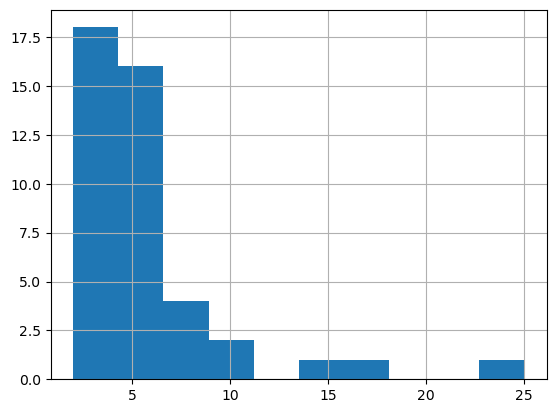

In [7]:
feat_categorical_nunique.hist();


💡 Como ponto de partida, que tal simplesmente remover todas as características que têm 7 valores únicos ou mais e aplicar a codificação one-hot no restante? Vamos manter a codificação ordinal e a seleção de características estatísticas para a próxima iteração do nosso pipeline.

❓ Armazene os nomes das características a serem codificadas em one-hot em uma lista chamada feat_categorical_small abaixo. Quantas características serão codificadas em one-hot?

In [8]:
# categorical features para one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)


In [9]:
# Quantidade de catgorias
len(feat_categorical_small)


34

🧪 Teste o código!

In [11]:
!pip install nbresult

In [12]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'features_overview',
    n=len(feat_categorical_small)
)

result.write()
result.check()


''

## 1.2 Baseline Pipe

### a) Pré-processamento

❓ Vamos codificar a linha de base do pré-processamento conforme descrito abaixo. Salve-a como `preproc_baseline`.

Para características categóricas:

* Impute simples com os valores mais frequentes
* Codificação One-Hot para características que têm menos de 7 valores únicos inicialmente
* Remova todas as outras características

Quanto às características numéricas:

* Impute simples com estratégia `média`
* Escala Min-Max

<details> <summary>ℹ️ Clique aqui para uma dica profissional</summary>

Se estiver confiante, você pode tentar a sintaxe mais curta do Sklearn, como `make_pipeline` ou `make_column_transformer`, em vez da sintaxe mais longa de `Pipeline` ou `ColumnTransformer`; também é útil se você quiser evitar dar nomes manualmente a cada etapa.

</details>

In [13]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop"
)

preproc_baseline


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000220607CF190>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown=...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

❓ Observe a **forma** do seu DataFrame após o pré-processamento e salve-a como `shape_preproc_baseline`.

In [14]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline


(1460, 183)

🧪 Test your code below

In [16]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())


### b) Add Estimator

❓ Adicione um modelo simples de Árvore de Decisão ao seu preproc_baseline e armazene-o na variável pipe_baseline.

In [17]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000220607CF190>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehote...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### c) Cross-Validação

❓ Leia as [regras de avaliação do concurso Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Qual métrica de desempenho você precisa? Ela está prontamente disponível no Sklearn?

Infelizmente, não está! Precisaremos criar nosso objeto personalizado `sklearn.metrics.scorer` para passar para qualquer validação cruzada ou pesquisa em grade. O processo é descrito abaixo:

1. Crie um scorer chamado `rmsle` usando [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) que pode ser passado como valor para o `kwarg` `scoring` da seguinte maneira:
    
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
    
2. Crie sua contraparte negativa, `rmsle_neg`, que é melhor quando _maximizada_; isso será útil mais tarde, já que o `GridSearchCV` sempre tenta _maximizar_ uma pontuação 😉
    
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [20]:
# OPTION 1: recode it all manually
def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)

    log_error = np.log(1+t) - np.log(1+p)

    return ((log_error**2).mean())**0.5

# This is our metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))


In [23]:
# OPTION 2 - re-use Sklearn's "mean_squared_log_error"

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)


❓ Realize a validação cruzada de 5 folds no seu pipe_baseline usando essa métrica para obter uma primeira visão do desempenho básico.

Armazene a pontuação média como score_baseline.

In [24]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline


0.2085569714063026

### d) Predict Baseline

❓ Faça previsões (y_pred_baseline) no conjunto de dados Kaggle test.csv que você armazenou na pasta data.

In [25]:
X_test = pd.read_csv("data/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline


array([129000., 157900., 192000., ..., 139000., 108000., 219500.])

❓ Por fim, armazene o seu arquivo CSV pronto para envio como submission_baseline.csv na pasta data. Leia cuidadosamente e compreenda o formato necessário do Kaggle e teste abaixo (você não precisa enviar esta linha de base para o Kaggle por enquanto).

In [26]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)


,Id,SalePrice
0,1461,129000.0


In [27]:
# Exporte os resultados
results.to_csv("data/submission_baseline.csv", header=True, index=False)


🧪 Test your code

In [28]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())


🏋️‍♀️ 2. ITERAÇÕES
===================

🎉 🎉 Parabéns por ter completamente construído um modelo básico! Agora, você verá o quão mais fácil é iterar e melhorar o desempenho 🚀

Agora, seu objetivo é melhorar suas previsões e enviá-las para o Kaggle **pelo menos 30 minutos antes do Resumo ⏳**

Temos algumas sugestões de melhorias abaixo: **escolha suas batalhas** e melhore **incrementalmente** seu pipeline conforme achar adequado!

**Estimadores**

* Conjuntos baseados em árvores (um must-try hoje); provavelmente os mais adequados para problemas com muitas características categóricas
* Stacking!
* XGBoost!

**Pré-processamento** (quando seu primeiro modelo de conjunto estiver funcionando)

* **Codificação Ordinal** de características categóricas com uma noção oculta de ordem em seus valores (por exemplo, "ruim", "médio", "bom")
* **Seleção Estatística de Características** para remover características inúteis (evita overfitting e reduz o tempo de treinamento)
* Prever `log(SalePrice)` em vez disso?
* 🤷

2.1 Iteração de Pré-processamento ♲
-----------------------------------

**⚠️ Volte aqui apenas depois de ter iterado nos seus estimadores na seção 2.2 ⚠️**

⏩ Me colapse se eu não estiver sendo usado!

### a) Ordinal Encoding (~1h)

❓ Olhe para a seguinte característica. Não poderia ser codificada de maneira inteligente numericamente?

```perl
ExterQual: Avalia a qualidade do material no exterior
		
       Ex	Excelente
       Gd	Bom
       TA	Média/Típica
       Fa	Ruim
       Po	Péssimo
```

💡 Felizmente, o `OrdinalEncoder` e seu argumento `categories` nos permite fazer exatamente isso! Confira abaixo e certifique-se de entender como isso funciona 👇

In [30]:
# Define uma ordem específica para as características
# Observação: se você alterar esta ordem, ela mudará a saída para .transform()
feature_A_sorted_values = ['bad', 'average', 'good']
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])


array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

❓ **Sua vez**: divida seu pré-processador categórico em

* `preproc_ordinal` para codificar de forma ordinal **algumas características** (de sua escolha)
* `preproc_nominal` para codificar one-hot as outras

<details> <summary>Dicas</summary>

* Você não conseguirá evitar a codificação direta dos nomes e valores ordenados das características! Seja organizado!
* É uma boa prática ordenar suas características em ordem alfabética para evitar surpresas desagradáveis.

</details>

In [31]:
feat_ordinal_dict = {
    # Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [32]:
# Define características numéricas de uma vez por todas.

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)


In [33]:
# Define características nominais para codificar one-hot como as restantes (não numéricas, não ordinais)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


In [34]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [35]:
pd.DataFrame(preproc.fit_transform(X,y)).head()


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### b) Seleção Estatística de Características (~30min)

Nosso objetivo é remover as características menos interessantes para limitar o overfitting e reduzir o tempo de treinamento.

🔥 Vamos fazer uso dos transformadores de [seleção de características](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) do Sklearn diretamente no seu pipeline!

❗️ Recomendamos que você tente **apenas a Opção 1 hoje**, para começar. As Opções 2 e 3 serão corrigidas no Resumo!

#### Opção 1 (Recomendada) - <font color=green>Seleção de Características Univariada</font>

_com base na informação mútua com o alvo `y`_

* Sinta-se à vontade para adicionar um filtro `SelectPercentile` ao final do seu pipeline `preproc`.
* Isso filtrará características que, individualmente, explicam menos o seu alvo!
* O teste estatístico que recomendamos passar para o `SelectPercentile` é o `mutual_info_regression`

<details> <summary markdown='span'>🤔 O que é informação mútua? Clique aqui!</summary>

* [Informação Mútua](https://en.wikipedia.org/wiki/Mutual_information) é uma distância **estatística** entre duas distribuições de probabilidade.
* A correlação é uma distância **linear** entre duas variáveis aleatórias.
* A Informação Mútua é mais geral e mede a redução de incerteza em Y após observar X.
* Por outro lado, se você já sabe que está lidando com variáveis suaves (como variáveis numéricas contínuas), às vezes a correlação pode fornecer mais informações sobre elas, por exemplo, se a relação entre elas for monótona.

Veja [esta animação](https://twitter.com/ari_seff/status/1409296508634152964)

</details>

In [36]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000220608470D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'))...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x000002205E288B80>))])

In [37]:
preproc.fit_transform(X, y).shape


(1460, 54)

#### Opção 2 - <font color=green>Seleção de Características Multivariada</font>

_com base em sua relação combinada com o alvo `y`_

🤔 Queremos remover características que não ajudam a prever nosso alvo mesmo quando combinadas com todas as outras.

1️⃣ Para fazer isso, lembre-se de que podemos usar a métrica [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) em combinação com um estimador! Ele treina um pipeline por característica para estimar qual característica faz nosso escore de desempenho _diminuir_ mais quando ela é embaralhada aleatoriamente. Essas seriam nossas características mais importantes, que não queremos remover.

A melhor parte é que o `scikit-learn` permite que você integre essa metodologia diretamente no seu pipeline `preproc` graças ao transformador [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html); isso removerá recursivamente as características menos importantes de acordo com o `cross_val_score`.

Quando você tem muitas características, no entanto, esse processo pode levar muito tempo para treinar.

2️⃣ Alternativamente, uma maneira mais rápida seria fazer uso de modelos que já produzem alguma medida de `feature_importance` ao serem ajustados. Por exemplo, árvores com `feature_importance_` baseado em Gini, ou regressões Lasso com `coef_` L1. O `scikit-learn` já possui o transformador [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) para fazer exatamente isso.

In [39]:
preproc_transformer_multi = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector_multi = SelectFromModel(
    RandomForestRegressor(),
    threshold = "median", # drop all multivariate features lower than the median correlation
)

preproc_multi = make_pipeline(
    preproc_transformer_multi,
    preproc_selector_multi
)

preproc_multi


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002205E40A550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'))...
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='median'))])

#### Opção 3 - Seleção <font color=green>Não Supervisionada</font>?

_filtre baseado apenas nas propriedades de `X`_

❓ Uma vitória rápida é remover características com a menor variância. Pense sobre isso: uma característica que só tem um valor é inútil (e tem uma variância de 0).

Sinta-se à vontade para adicionar um [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) ao final do seu pipeline!

In [41]:
def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop"
    )

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector
    )

    return preproc.fit_transform(X).shape[1]


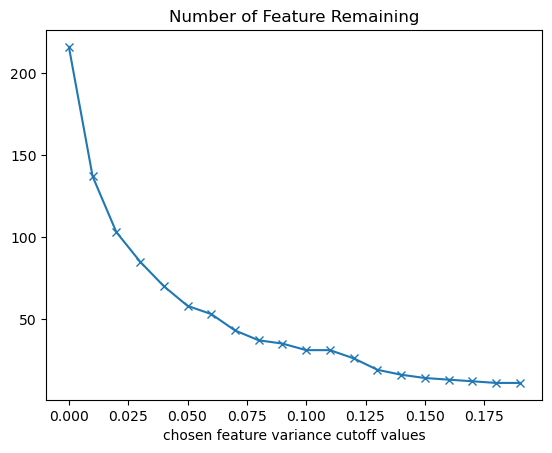

In [42]:
cutoff_values = np.arange(0, 0.2, 0.01)

plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')

plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");


☝️ Poderíamos decidir colocar um limite de 0.025 nas características categóricas para reduzir o número delas pela metade ou mais.

❓ Além disso, podemos verificar a correlação entre nossas **características numéricas** apenas

* Use a [correlação de Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combinada com um mapa de calor para verificar visualmente se alguma característica **numérica** se correlaciona quase que inteiramente com outras
* Use o `VIF` de `statsmodels` para verificar quais características têm a maior multicolinearidade

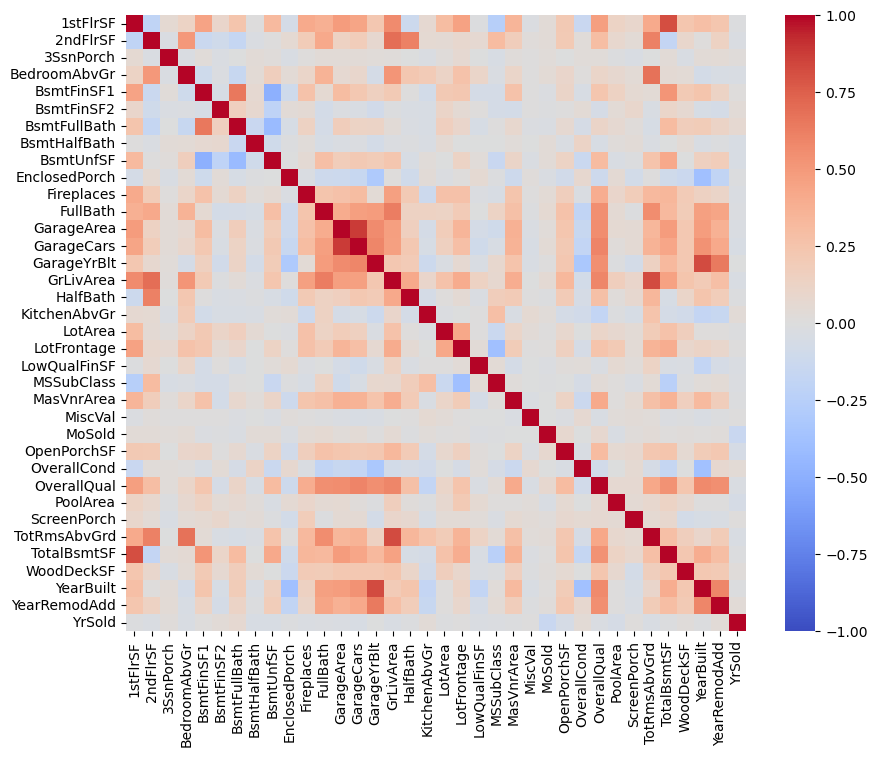

In [43]:
corr_num = X[feat_numerical].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);


In [51]:
# Verifique quais colunas remover com base na alta correlação
num_corr_threshold = 0.95

corr_num = X[feat_numerical].corr()
corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool_)).abs()

num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
num_col_to_drop



[]

❓ Para **características ordinais**, podemos usar a [correlação de postos de Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) para verificar se algumas características **codificadas ordinalmente** são quase inteiramente "ordenadas" de maneira semelhante às outras. Sinta-se à vontade para plotar um mapa de calor novamente.

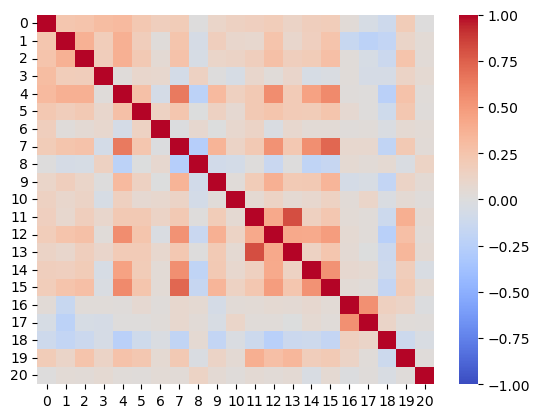

In [52]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))

sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1);


❓ Agora, sinta-se à vontade para criar um "filtro" em seu pipeline que remove qualquer característica além de um determinado limite de correlação (Spearman + Pearson); você precisará de uma classe de transformador personalizada.

In [49]:
!pip install numpy

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_corr_threshold=0.95):
        self.num_corr_threshold = num_corr_threshold

    def fit(self, X, y=None):
        # Identifica colunas numéricas
        feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

        # Calcula a matriz de correlação
        corr_num = X[feat_numerical].corr()

        # Cria matriz triangular superior, usando np.bool_ para o tipo de dado
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool_)).abs()

        # Identifica colunas para descartar com base no limiar de correlação
        self.num_col_to_drop = [column for column in upper.columns if any(upper[column] > self.num_corr_threshold)]
        
        # Mantém o registro das colunas numéricas originais
        self.num_col = X[feat_numerical].columns

        return self

    def transform(self, X, y=None):
        # Cria DataFrame e descarta colunas com alta correlação
        df = pd.DataFrame(X, columns=self.num_col)
        return df.drop(columns=self.num_col_to_drop)

# Exemplo de uso
# CustomFeatureSelector(num_corr_threshold=0.2).fit_transform(X[feat_numerical]).head(2)


### 🥷 Solução Apenas: Outras Transformações?

### c) Tratar Características Cíclicas

❓ Temos algumas características relacionadas ao tempo, por que não transformá-las em características cíclicas?

In [55]:
# Tratar Características Cíclicas
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


### d) Engenharia do Alvo (~15min)

❓ Nos foi pedido para minimizar o RMS**L**E. Que tal transformarmos nosso alvo para prever diretamente seu `log`?

* Confira o histograma do alvo `y`
* Variáveis normalmente distribuídas devem ser mais fáceis de prever com modelos lineares ou paramétricos
* Crie `y_log` e suas novas métricas de desempenho
* Não se esqueça de tomar a exponencial de suas previsões no final!

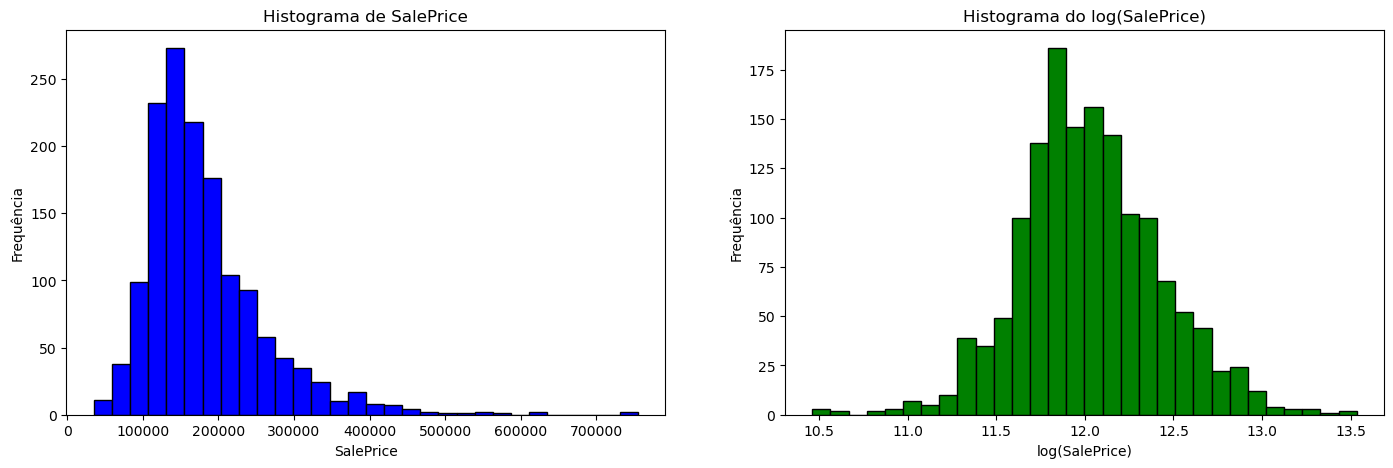

In [56]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

# Subplot para o histograma original
plt.subplot(1, 2, 1)
plt.hist(y, bins=30, color='blue', edgecolor='black')
plt.title('Histograma de SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequência')

# Subplot para o histograma dos dados transformados
plt.subplot(1, 2, 2)
plt.hist(y_log, bins=30, color='green', edgecolor='black')
plt.title('Histograma do log(SalePrice)')
plt.xlabel('log(SalePrice)')
plt.ylabel('Frequência')

plt.show()


In [57]:
# Crie seu novo marcador para minimizar
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Crie seu novo artilheiro para maximizar
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)


### 2.2 Model Iteration ♻

#### a) Versão Final do Pipeline de Pré-processamento

❓ Aconselhamos que você comece com uma definição nova abaixo para que você possa atualizá-la rapidamente conforme necessário e, em seguida, experimentar muitos tipos de modelos para encontrar o melhor possível (você pode tentar GridSearch ou ir modelo por modelo)

In [58]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022061CAF690>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'))...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x000002205E288B80>))])

In [59]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)

preproc_fitted_log.transform(X).shape


(1460, 108)

In [60]:
# SOLUCAO
allow_grid_searching = True # Use True para ativar o GridSearch nas células do notebook abaixo

# Armazenar em cache a etapa de pré-processamento do pipeline
cachedir = mkdtemp()


#### b) Modelos Lineares (Lasso, Ridge, ElasticNet, SGDRegressor, etc.)

In [61]:
# Ridge com normal target
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()


c:\Users\math_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\math_\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\math_\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\math_\AppData\Local\Temp\ipykernel_47560\1300514440.py", line 4, in <lambda>
    rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)
                                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\math_\anaconda3\Lib\site-packages\sklearn\utils\_param_validatio

nan

In [62]:
# Ridge com log-target (much better)
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()


0.14015872467080373

In [63]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5, 2, num=20)}

    search_ridge = GridSearchCV(
        pipe_ridge,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_ridge.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_ridge.best_params_}')
    print(f'Best score 👉 {search_ridge.best_score_}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits

----------------------------------------

Best params 👉 {'ridge__alpha': 2.0}
Best score 👉 -0.13990756622281303


#### c) KNN

In [65]:
model = KNeighborsRegressor()

pipe_knn = make_pipeline(preproc, model)


In [66]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()


0.2016865828125744

In [67]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}

    search_knn = GridSearchCV(
        pipe_knn,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_knn.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_knn.best_params_}')
    print(f'Best score 👉 {search_knn.best_score_}')


Fitting 3 folds for each of 11 candidates, totalling 33 fits

----------------------------------------

Best params 👉 {'kneighborsregressor__n_neighbors': 6}
Best score 👉 -0.20373499067687825


#### d) SVM

In [68]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()


0.13796158933862188

In [69]:
model = SVR(kernel='rbf', C = 10)

pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()


0.13532997316076947

In [70]:
# GridSearch
if allow_grid_searching:
    param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm_rbf = GridSearchCV(
        pipe_svm_rbf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm_rbf.fit(X, y_log);

    svm_rbf_best = search_svm_rbf.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_svm_rbf.best_params_}')
    print(f'Best score 👉 {search_svm_rbf.best_score_}')


Fitting 5 folds for each of 30 candidates, totalling 150 fits

----------------------------------------

Best params 👉 {'svr__C': 1, 'svr__epsilon': 0.01}
Best score 👉 -0.1270345398774511


#### e) Árvores

In [71]:
model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.010003816656193962
0.18894277772061632


#### f) Floresta Aleatória

In [72]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.007781379340901581
0.16191052983348247


#### g) Boosted Trees

In [73]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


c:\Users\math_\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\math_\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\math_\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\math_\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\math_\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.00801067615897028
0.14156290753974018


In [74]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.009058605945718156
0.12701399726233892


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END gradientboostingregressor__max_features=76, gradientboostingregressor__n_estimators=163; total time=   1.8s
[CV] END gradientboostingregressor__max_features=76, gradientboostingregressor__n_estimators=163; total time=   1.6s
[CV] END gradientboostingregressor__max_features=76, gradientboostingregressor__n_estimators=163; total time=   1.6s
[CV] END gradientboostingregressor__max_features=76, gradientboostingregressor__n_estimators=163; total time=   1.6s
[CV] END gradientboostingregressor__max_features=76, gradientboostingregressor__n_estimators=163; total time=   1.5s
[CV] END gradientboostingregressor__max_features=79, gradientboostingregressor__n_estimators=286; total time=   2.5s
[CV] END gradientboostingregressor__max_features=79, gradientboostingregressor__n_estimators=286; total time=   2.4s
[CV] END gradientboostingregressor__max_features=79, gradientboostingregressor__n_estimators=286; total time=   2.3s
[CV]

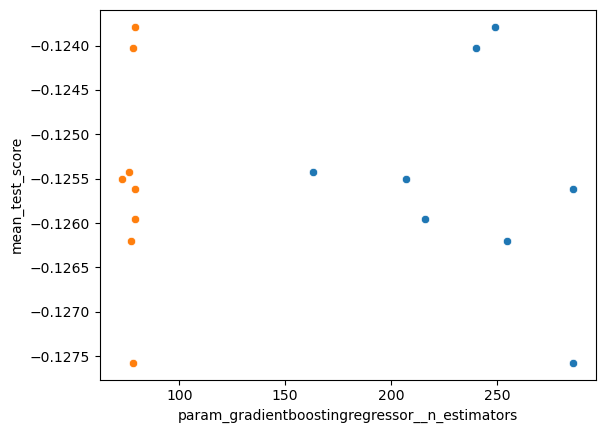

In [76]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

if allow_grid_searching:
    grid = {
        'gradientboostingregressor__n_estimators': stats.randint(50, 300),
        # 'gradientboostingregressor__learning_rate': stats.uniform(0.05, 0.3),
        # 'gradientboostingregressor__loss': ['lad', 'huber', 'quantile'],
        # 'gradientboostingregressor__max_depth': stats.randint(3, 5),
        # 'gradientboostingregressor__min_samples_split': stats.randint(2, 10),
        # 'gradientboostingregressor__subsample': [0.95, 1], # 1 default
        'gradientboostingregressor__max_features': stats.randint(int(len(X.columns) * 0.9), len(X.columns))  # default None, i.e = n_features
    }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2)

    # Fit data to GridSearch
    search_gb.fit(X, y_log)

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_gb.best_params_}')
    print(f'Best score 👉 {search_gb.best_score_}')

    # Plot results of GridSearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)

    sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)


#### h) Stacking

In [77]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    weights = [1, 1, 1, 1], # to equally weight the models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


0.010336497997340106
0.12154563009358318


In [78]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


0.010093468740801605
0.12105139553162245


#### i) XGBoost

In [79]:
# Cria um teste de avaliação apenas para fins de parada antecipada (XGBOOST e Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)


In [81]:
# Instanciar modelo
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)


In [82]:
# Opção 1: Integrar XGB ao pipeline do Sklearn
# Permite GridSearchCV seus melhores hiperparâmetros
pipe_xgb = make_pipeline(preproc, model_xgb)

cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()


0.15049960685198496

c:\Users\math_\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\math_\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Validation Score 0.1460354309215069


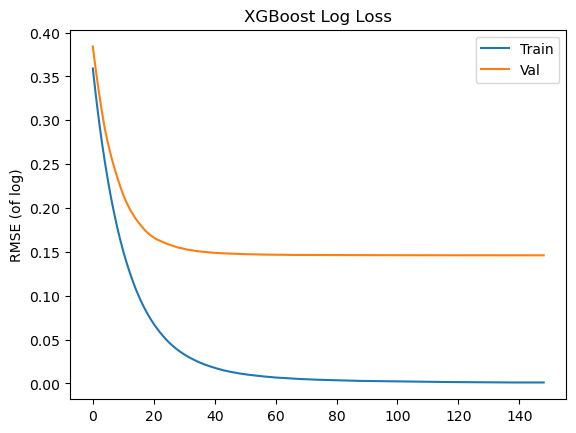

In [83]:
# Opção 2: Use a biblioteca XGBoost para ajustá-la
# Permite que você use um critério `early_stopping` com uma fenda Train/Val
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb.fit(
    X_train_preproc,
    y_train_log,
    verbose=False,
    eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
    eval_metric=["rmse"],
    early_stopping_rounds=10
)

# Retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# Plot RMSLE loss
fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))


In [93]:
!pip install lightgbm
!pip install catboost

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 196.9 kB/s eta 0:00:07
   - -------------------------------------- 0.1/1.3 MB 297.7 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.3 MB 262.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.3 MB 309.1 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.3 MB 309.1 kB/s eta 0:00:04
   ---- ----------------------------------- 0.1/1.3 MB 355.0 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/1.3 MB 353.1 kB/s eta 0:00:04
   ----- -------------------------------

In [95]:
# Importando os pacotes necessários
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Configuração inicial do modelo LightGBM
lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)
# Treinamento do modelo LightGBM
lgbm_model.fit(X_train, y_train)
# Avaliação do modelo LightGBM
lgbm_pred = lgbm_model.predict(X_test)

# Configuração inicial do modelo CatBoost
catboost_model = CatBoostRegressor(iterations=100, depth=3, learning_rate=0.1, loss_function='RMSE')
# Treinamento do modelo CatBoost
catboost_model.fit(X_train, y_train, verbose=False)
# Avaliação do modelo CatBoost
catboost_pred = catboost_model.predict(X_test)


NameError: name 'y_train' is not defined

# 🏅 APRESENTAÇÃO FINAL

Descubra sua pontuação real no teste enviando para o Kaggle!

In [84]:
X_test = pd.read_csv("data/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])


In [85]:
# Adicionando colunas ao X_test de acordo com o que fizemos no X
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test.drop(columns=['MoSold'], inplace=True)


In [86]:
pipe_stacking.fit(X, y_log)

predictions_log = pipe_stacking.predict(X_test)
predictions = np.exp(predictions_log)


In [87]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results


,Id,SalePrice
0,1461,118818.822501
1,1462,151980.566822
2,1463,178914.352469
3,1464,189470.854680
4,1465,194179.547775
...,...,...
1454,2915,77691.581160
1455,2916,79749.307637
1456,2917,166134.526154
1457,2918,112836.025028


In [88]:
# Exporte os resultados
results.to_csv("data/submission_final.csv", header=True, index=False)


## Agora vamos para a nossa ponderada!

1. Descreva aqui as diferenças de treinamento que você encontrou entre os treinamentos de Ensemble. Passe por todos os métodos. 
2. Descreva as modificações que você porpôs.

Abra uma nova célula para a resposta.

### Descrição das Diferenças de Treinamento entre os Métodos de Ensemble

1. **Tree-based Ensembles**:
   - **Descrição**: Esses modelos combinam várias árvores de decisão para formar um modelo mais robusto e preciso. Exemplos comuns incluem Random Forest e Gradient Boosting.
   - **Diferenças de Treinamento**:
     - **Random Forest**: Utiliza um método chamado bagging, onde diferentes árvores são treinadas em paralelo em subconjuntos aleatórios dos dados. Cada árvore faz sua previsão, e a previsão final é uma média (ou maioria) das previsões de todas as árvores.
     - **Gradient Boosting**: As árvores são construídas de forma sequencial, com cada nova árvore tentando corrigir os erros da árvore anterior. Diferentemente do Random Forest, aqui há uma forte interdependência entre as árvores.

2. **Stacking**:
   - **Descrição**: Combina as previsões de vários modelos de aprendizado de máquina para fazer uma previsão final. 
   - **Diferenças de Treinamento**: Em stacking, modelos diferentes (podem ser de tipos distintos) são treinados independentemente. Suas previsões são então usadas como entradas para um meta-modelo final que faz a previsão final. Esta abordagem permite que o modelo aprenda como melhor combinar as previsões dos modelos base.

3. **XGBoost**:
   - **Descrição**: É uma implementação otimizada e altamente eficiente do Gradient Boosting. 
   - **Diferenças de Treinamento**: XGBoost oferece melhorias como tratamento eficiente de valores ausentes, suporte a paralelização e regularização, que ajudam a evitar overfitting. Ele também permite ajustes finos com uma ampla gama de hiperparâmetros.

### Melhoria com LightGBM e CatBoost

Implementamos dois poderosos métodos de ensemble - LightGBM e CatBoost - para aprimorar o desempenho do nosso modelo. Ambos são conhecidos por sua eficiência e eficácia, especialmente em conjuntos de dados com uma grande quantidade de variáveis categóricas.



#### LightGBM
- **Descrição**: LightGBM é uma implementação de gradient boosting framework que usa árvores baseadas em algoritmos de aprendizado baseados em gradiente. É projetado para ser distribuído e eficiente com os seguintes benefícios:
  - Maior velocidade de treinamento e maior eficiência.
  - Menor uso de memória.
  - Melhor precisão.
  - Suporte para computação paralela e GPU.
- **Implementação**: No nosso projeto, configuramos o modelo LightGBM com parâmetros padrão e treinamos com o nosso conjunto de dados. Isso é esperado para nos ajudar a capturar complexidades nos dados que modelos mais simples podem não conseguir.



#### CatBoost
- **Descrição**: CatBoost é um algoritmo de 'boosting' que utiliza árvores de decisão, especialmente otimizado para variáveis categóricas. Suas principais características incluem:
  - Tratamento automático de variáveis categóricas, o que significa que não é necessário realizar extenso pré-processamento para codificar essas variáveis.
  - Robustez a diferentes distribuições de dados e fácil integração com aplicações de aprendizado profundo.
- **Implementação**: Implementamos o CatBoost com parâmetros iniciais padrão. O modelo é treinado com nossos dados e avaliado em um conjunto de teste separado.

Essas adições visam melhorar a acurácia do nosso modelo e fazer previsões mais precisas.
